# Setup

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

# Causal-Masked MLP Mixer

In [ ]:
#define a MLP Mixer based causal-language-model using weight masking

class CausalLinear(nn.Module):
    """
    A linear layer with a triangular (causal) mask applied to the weight matrix.
    This ensures each position i cannot use info from positions > i.
    """
    def __init__(self, in_dim: int, out_dim: int):
        
        super().__init__()

        if in_dim != out_dim:
            raise NotImplementedError("Only square matrices are supported.")

        # Standard weight + bias
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim))
        self.bias = nn.Parameter(torch.zeros(out_dim))

        # triangular mask
        mask = torch.triu(torch.ones(in_dim, out_dim))
        self.register_buffer('mask', mask)

    def forward(self, x):
        """
        x shape: (batch, embed_dim, seq_len)
        """
        B, E, S = x.shape
        W = self.weight * self.mask    # elementwise multiply
        x_reshaped = x.reshape(B * E, S)  # (B*E, S)
        out = x_reshaped @ W           # (B*E, S)
        out = out + self.bias          # broadcast bias
        out = out.view(B, E, S)        # reshape back

        return out

class MixerBlock(nn.Module):
    
    def __init__(
        self,
        hidden_dim:int,
        seq_len:int,
        expansion_factor:int=2,
        dropout:float=0.1):

        super(MixerBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.expansion_factor = expansion_factor

        #channel-norm
        self.channel_norm = nn.RMSNorm(hidden_dim)

        #channel-mixing layer
        self.channel_mixing_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * expansion_factor),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * expansion_factor, hidden_dim)
        )

        #token-norm
        self.token_norm = nn.RMSNorm(hidden_dim)

        #token-mixing layer
        self.token_mixing_layer = nn.Sequential(
            CausalLinear(seq_len, seq_len),
            nn.SiLU(),
            nn.Dropout(dropout),
            CausalLinear(seq_len, seq_len)
        )

    def forward(self, x):

        res = x
        x = self.channel_norm(x)
        x = self.channel_mixing_layer(x)
        x = x + res

        res = x
        x = self.token_norm(x)
        x = x.transpose(1, 2)
        x = self.token_mixing_layer(x)
        x = x.transpose(1, 2)
        x = x + res

        return x

class MLPMixer(nn.Module):
    
    def __init__(
        self,
        vocab_size:int,
        hidden_dim:int,
        seq_len:int,
        num_blocks:int):

        super(MLPMixer, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_blocks = num_blocks

        # Input Embedding
        self.input_layer = nn.Embedding(vocab_size, hidden_dim)

        # Mixer Blocks
        self.mixer_blocks = nn.ModuleList(
            [MixerBlock(hidden_dim, seq_len) for _ in range(num_blocks)]
        )

        # Output Layer
        self.output_layer = nn.Linear(hidden_dim, vocab_size, bias=False)

        # Tie input and output layer weights
        self.output_layer.weight = self.input_layer.weight

        # Initialize weights
        self._init_weights()

        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, CausalLinear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x, labels=None):

        x = self.input_layer(x)
        for block in self.mixer_blocks:
            x = block(x)
        logits = self.output_layer(x)

        if not labels is None:

            logits = logits.view(-1, self.vocab_size)
            labels = labels.view(-1)
            loss = self.loss_fn(logits, labels)
            return loss, logits

        else:
            return logits

In [ ]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['vocab_size', 'hidden_dim', 'seq_len', 'num_blocks']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [ ]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    print(params)
    model = MLPMixer(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare Dataset

In [ ]:
#load text
with open('shakespeare/shakespeare.data', 'r', encoding='utf-8') as f:
    text = f.read()
print(len(text))

# #load text
# with open('mixer/TinyStories-train.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
# print(len(text))

#get unique characters
all_chars = sorted(list(set(text)))
vocab_size = len(all_chars)
print(f"Unique characters: {vocab_size}")

In [ ]:
char2id = {ch: i for i, ch in enumerate(tqdm(all_chars))}
id2char = {i: ch for i, ch in enumerate(tqdm(all_chars))}
tokens = [char2id[ch] for ch in tqdm(text)]

## Train

In [ ]:
# Hyperparameters
hidden_dim = 128  # Size of hidden layers
seq_len = 128
num_blocks = 6
batch_size = 32
num_epochs = 2000

In [ ]:
# Initialize the model
model = MLPMixer(vocab_size, hidden_dim, seq_len, num_blocks).to(device)
print(f"Model has {model.count_params():,} parameters")

In [ ]:
lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [ ]:
pad_size = seq_len - (len(tokens) % seq_len) + 1 #we add one to account for x-y offset
pad = [char2id[' ']] * pad_size
train_data = torch.tensor(tokens + pad, dtype=torch.long).to(device)
print(len(train_data))

In [ ]:
losses = []
accuracies = []

In [ ]:
model.train()

#get index every seq_len, starting at idx 0
idx = list(range(0, len(train_data)-1, seq_len))
num_batches = len(idx) // batch_size
if len(idx) % batch_size != 0:
    num_batches += 1

SHUFFLE_BATCHES = True
random.seed(42)

for epoch in tqdm(range(num_epochs)):
    print(f"EPOCH {epoch+1}/{num_epochs}")

    if SHUFFLE_BATCHES:
        random.shuffle(idx)

    batch_nums = list(range(num_batches))
    for i in batch_nums:
        
        batch_start = i * batch_size
        batch_end = min((i+1) * batch_size, len(idx))
        batch_idx = idx[batch_start:batch_end]

        # Get the batch data
        batch = torch.stack([train_data[i:i+seq_len+1] for i in batch_idx], dim=0)
        x = batch[:, :-1].contiguous()
        y = batch[:, 1:].contiguous()

        # Forward pass
        optimizer.zero_grad()
        loss, output = model(x, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-num_batches:]) / num_batches
    print(f"Average loss: {avg_loss:.4f}")

In [ ]:
save_checkpoint(model, {
    'vocab_size': vocab_size,
    'hidden_dim': hidden_dim,
    'seq_len': seq_len,
    'num_blocks': num_blocks
}, optimizer, losses, filename="mixer/checkpoint_CLM.pth")

In [ ]:
model, optimizer, losses = load_checkpoint("mixer/checkpoint_CLM.pth")

In [ ]:
# Plot the loss curve
downsample = 1
window = 10

temp = []
for epoch in losses[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F

def evaluate(model, prompt, generation_length=100, seq_len=128):
    """
    Generates text from the model given a prompt.
    
    Args:
        model: The trained MLPMixer model.
        prompt (str): The prompt to condition generation on.
        generation_length (int): Number of characters to generate.
        seq_len (int): The sequence length the model expects.
        temperature (float): Temperature parameter for sampling.
    
    Returns:
        str: The prompt plus the generated text.
    """
    model.eval()  # Set model to evaluation mode
    # Convert prompt into a list of token ids
    tokens = [char2id[c] for c in prompt]
    
    # Autoregressive generation loop
    with torch.no_grad():
        for _ in range(generation_length):
            # Prepare the input context:
            # If the context is shorter than seq_len, pad to the left (using the token for space)
            if len(tokens) < seq_len:
                # pad with the space character (or any chosen pad token)
                padded = [char2id[' ']] * (seq_len - len(tokens)) + tokens
            else:
                padded = tokens[-seq_len:]
            
            # Convert to a tensor and add batch dimension
            x = torch.tensor(padded, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, seq_len)
            
            # Get logits from the model; output shape is (1, seq_len, vocab_size)
            logits = model(x)

            predictions = torch.argmax(logits, dim=-1)

            #intermediate string output
            temp = [id2char[t] for t in predictions[0].tolist()]
            print(''.join(temp))

            next_token = predictions[0][-1].item()
            tokens.append(next_token)
    
    # Convert the list of tokens back to a string
    generated_text = ''.join([id2char[t] for t in tokens])
    return generated_text

# Example usage:
prompt = "We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely;"
print(len(prompt))
generated = evaluate(model, prompt, generation_length=100, seq_len=seq_len)
print("Generated text:")
print(generated)

# Toeplitz Causal MLP Mixer

In [211]:
#define a MLP Mixer based causal-language-model using weight masking

class ToeplitzCausalLinear(nn.Module):
    """
    A linear layer with a triangular (causal) mask applied to the weight matrix.
    This ensures each position i cannot use info from positions > i.
    """
    def __init__(self, dim: int):
        
        super().__init__()

        # Standard weight + bias
        self.weight = nn.Parameter(torch.randn(1, dim))
        self.bias = nn.Parameter(torch.zeros(dim))

    def vector_to_matrix(self, v):
        """
        Given a vector v of shape (m,), returns an (m x m) matrix M
        where M[i, j] = v[j - i] if j >= i, and 0 otherwise.
        
        For example, if v = [a, b, c, d] then M will be:
        
        [ a  b  c  d ]
        [ 0  a  b  c ]
        [ 0  0  a  b ]
        [ 0  0  0  a ]
        """
        v = v.reshape(-1)  # Ensure v is a 1D tensor
        m = v.shape[0]
        # Create index grids for rows and columns
        i, j = torch.meshgrid(torch.arange(m, device=v.device),
                                torch.arange(m, device=v.device), 
                                indexing='ij')
        # j - i gives the offset into v. When j < i, we want a 0.
        M = torch.where(j >= i, v[j - i], torch.zeros(m, m, device=v.device, dtype=v.dtype))
        return M

    def forward(self, x):
        """
        x shape: (batch, embed_dim, seq_len)
        """
        B, E, S = x.shape
        W = self.vector_to_matrix(self.weight)
        x_reshaped = x.reshape(B * E, S)  # (B*E, S)
        out = x_reshaped @ W           # (B*E, S)
        out = out + self.bias          # broadcast bias
        out = out.view(B, E, S)        # reshape back

        return out

class MixerBlock(nn.Module):
    
    def __init__(
        self,
        hidden_dim:int,
        seq_len:int,
        expansion_factor:int=2,
        dropout:float=0.1):

        super(MixerBlock, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.expansion_factor = expansion_factor

        #channel-norm
        self.channel_norm = nn.RMSNorm(hidden_dim)

        #channel-mixing layer
        self.channel_mixing_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * expansion_factor),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * expansion_factor, hidden_dim)
        )

        #token-norm
        self.token_norm = nn.RMSNorm(hidden_dim)

        #token-mixing layer
        self.token_mixing_layer = nn.Sequential(
            ToeplitzCausalLinear(seq_len),
            nn.SiLU(),
            nn.Dropout(dropout),
            ToeplitzCausalLinear(seq_len)
        )

    def forward(self, x):

        res = x
        x = self.channel_norm(x)
        x = self.channel_mixing_layer(x)
        x = x + res

        res = x
        x = self.token_norm(x)
        x = x.transpose(1, 2)
        x = self.token_mixing_layer(x)
        x = x.transpose(1, 2)
        x = x + res

        return x

class MLPMixer(nn.Module):
    
    def __init__(
        self,
        vocab_size:int,
        hidden_dim:int,
        seq_len:int,
        num_blocks:int):

        super(MLPMixer, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_blocks = num_blocks

        # Input Embedding
        self.input_layer = nn.Embedding(vocab_size, hidden_dim)

        # Mixer Blocks
        self.mixer_blocks = nn.ModuleList(
            [MixerBlock(hidden_dim, seq_len) for _ in range(num_blocks)]
        )

        # Output Layer
        self.output_layer = nn.Linear(hidden_dim, vocab_size, bias=False)

        # Tie input and output layer weights
        self.output_layer.weight = self.input_layer.weight

        # Initialize weights
        self._init_weights()

        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, ToeplitzCausalLinear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x, labels=None):

        x = self.input_layer(x)
        for block in self.mixer_blocks:
            x = block(x)
        logits = self.output_layer(x)

        if not labels is None:

            logits = logits.view(-1, self.vocab_size)
            labels = labels.view(-1)
            loss = self.loss_fn(logits, labels)
            return loss, logits

        else:
            return logits

In [ ]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['vocab_size', 'hidden_dim', 'seq_len', 'num_blocks']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [ ]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    print(params)
    model = MLPMixer(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare Dataset

In [ ]:
#load text
with open('shakespeare/shakespeare.data', 'r', encoding='utf-8') as f:
    text = f.read()
print(len(text))

# #load text
# with open('mixer/TinyStories-train.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
# print(len(text))

#get unique characters
all_chars = sorted(list(set(text)))
vocab_size = len(all_chars)
print(f"Unique characters: {vocab_size}")

In [ ]:
char2id = {ch: i for i, ch in enumerate(tqdm(all_chars))}
id2char = {i: ch for i, ch in enumerate(tqdm(all_chars))}
tokens = [char2id[ch] for ch in tqdm(text)]

## Train

In [227]:
# Hyperparameters
hidden_dim = 512  # Size of hidden layers
seq_len = 512
num_blocks = 6
batch_size = 32
num_epochs = 2000

In [228]:
# Initialize the model
model = MLPMixer(vocab_size, hidden_dim, seq_len, num_blocks).to(device)
print(f"Model has {model.count_params():,} parameters")

Model has 6,352,384 parameters


In [229]:
lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [230]:
pad_size = seq_len - (len(tokens) % seq_len) + 1 #we add one to account for x->y next-token-pred offset
pad = [char2id[' ']] * pad_size
train_data = torch.tensor(tokens + pad, dtype=torch.long).to(device)
print(len(train_data))

1115649


In [231]:
losses = []
accuracies = []

In [232]:
model.train()

#get index every seq_len, starting at idx 0
idx = list(range(0, len(train_data)-1, seq_len))
num_batches = len(idx) // batch_size
if len(idx) % batch_size != 0:
    num_batches += 1

SHUFFLE_BATCHES = True
random.seed(42)

for epoch in tqdm(range(num_epochs)):
    print(f"EPOCH {epoch+1}/{num_epochs}")

    if SHUFFLE_BATCHES:
        random.shuffle(idx)

    batch_nums = list(range(num_batches))
    for i in batch_nums:
        
        batch_start = i * batch_size
        batch_end = min((i+1) * batch_size, len(idx))
        batch_idx = idx[batch_start:batch_end]

        # Get the batch data
        batch = torch.stack([train_data[i:i+seq_len+1] for i in batch_idx], dim=0)
        x = batch[:, :-1].contiguous()
        y = batch[:, 1:].contiguous()

        # Forward pass
        optimizer.zero_grad()
        loss, output = model(x, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-num_batches:]) / num_batches
    print(f"Average loss: {avg_loss:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

EPOCH 1/2000
Average loss: 4.5805
EPOCH 2/2000
Average loss: 3.1433
EPOCH 3/2000
Average loss: 2.8725
EPOCH 4/2000
Average loss: 2.7542
EPOCH 5/2000
Average loss: 2.6854
EPOCH 6/2000
Average loss: 2.6448
EPOCH 7/2000
Average loss: 2.6142
EPOCH 8/2000
Average loss: 2.5938
EPOCH 9/2000
Average loss: 2.5770
EPOCH 10/2000
Average loss: 2.5654
EPOCH 11/2000
Average loss: 2.5533
EPOCH 12/2000
Average loss: 2.5433
EPOCH 13/2000
Average loss: 2.5356
EPOCH 14/2000
Average loss: 2.5278
EPOCH 15/2000
Average loss: 2.5236
EPOCH 16/2000
Average loss: 2.5201
EPOCH 17/2000
Average loss: 2.5155
EPOCH 18/2000
Average loss: 2.5102
EPOCH 19/2000
Average loss: 2.5090
EPOCH 20/2000
Average loss: 2.5050
EPOCH 21/2000
Average loss: 2.5023
EPOCH 22/2000
Average loss: 2.5004
EPOCH 23/2000
Average loss: 2.4974
EPOCH 24/2000
Average loss: 2.4941
EPOCH 25/2000
Average loss: 2.4930
EPOCH 26/2000
Average loss: 2.4921
EPOCH 27/2000
Average loss: 2.4909
EPOCH 28/2000
Average loss: 2.4870
EPOCH 29/2000
Average loss: 2

In [233]:
save_checkpoint(model, {
    'vocab_size': vocab_size,
    'hidden_dim': hidden_dim,
    'seq_len': seq_len,
    'num_blocks': num_blocks
}, optimizer, losses, filename="shakespeare/checkpoints/mixer/checkpoint_tMLP.pth")

Checkpoint saved with loss 0.1467


In [234]:
model, optimizer, losses = load_checkpoint("shakespeare/checkpoints/mixer/checkpoint_tMLP.pth")

{'vocab_size': 65, 'hidden_dim': 512, 'seq_len': 512, 'num_blocks': 6}
Checkpoint loaded: loss 0.1467


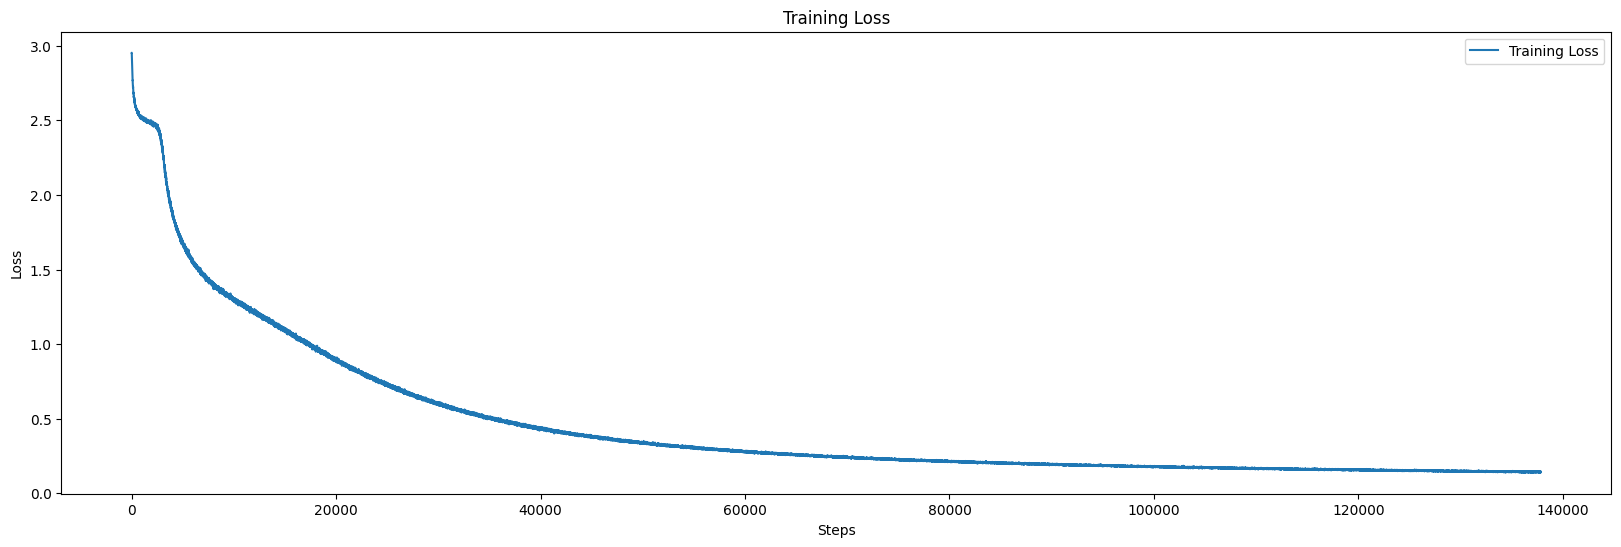

In [235]:
# Plot the loss curve
downsample = 1
window = 10

temp = []
for epoch in losses[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [238]:
import torch
import torch.nn.functional as F

def evaluate(model, prompt, generation_length=100, seq_len=128):
    """
    Generates text from the model given a prompt.
    
    Args:
        model: The trained MLPMixer model.
        prompt (str): The prompt to condition generation on.
        generation_length (int): Number of characters to generate.
        seq_len (int): The sequence length the model expects.
        temperature (float): Temperature parameter for sampling.
    
    Returns:
        str: The prompt plus the generated text.
    """
    model.eval()  # Set model to evaluation mode
    # Convert prompt into a list of token ids
    tokens = [char2id[c] for c in prompt]
    
    # Autoregressive generation loop
    with torch.no_grad():
        for _ in range(generation_length):
            # Prepare the input context:
            # If the context is shorter than seq_len, pad to the left (using the token for space)
            if len(tokens) < seq_len:
                # pad with the space character (or any chosen pad token)
                padded = [char2id[' ']] * (seq_len - len(tokens)) + tokens
            else:
                padded = tokens[-seq_len:]
            
            # Convert to a tensor and add batch dimension
            x = torch.tensor(padded, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, seq_len)
            
            # Get logits from the model; output shape is (1, seq_len, vocab_size)
            logits = model(x)

            predictions = torch.argmax(logits, dim=-1)

            #intermediate string output
            temp = [id2char[t] for t in predictions[0].tolist()]
            # print(''.join(temp))

            next_token = predictions[0][-1].item()
            tokens.append(next_token)
    
    # Convert the list of tokens back to a string
    generated_text = ''.join([id2char[t] for t in tokens])
    return generated_text

# Example usage:
prompt = "We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely;"
print(len(prompt))
generated = evaluate(model, prompt, generation_length=300, seq_len=seq_len)
print("Generated text:")
print(generated)

208
Generated text:
We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely;
but there's come to be a ll hip ell what show.

LUCIO:
There was not at the trial desperate,
My words be I have show'd to heaven grant's hours
Are pleasure to be done, to ste the city affect.

GLOUCESTER:
You take my leave to make my voice of all,
Provoke me for the state.

MERCUTIO:
The solemn of 
